# RPZ Assignment: Logistic Regression

**Detailed BRUTE upload instructions at the end of this notebook.**

## Introduction

In this labs we will build a logistic regression model for a letter/digit classification tasks. We will start with simple 1D measurement in order to be able to visualise relevant variables and characteristics of the solution. We then move on to a MNIST digit classification problem and will work in 784-dimensional space.

It has been shown at the lecture that for many practical problems, the **log odds** $a(x)$ can be written as a linear function of the input $x$

$$
a(x) = \ln\frac{p_{K|x}(1|x)}{p_{K|x}(2|x)} = w\cdot x\;,
$$
where the original data vector $x$ has been augmented by adding 1 as its first component (corresponding to the bias in the linear function). It follows that the aposteriori probabilities have then the form of a sigmoid function acting on a linear function of $x$

$$
p_{K|x}(k|x) = \frac{1}{1+e^{-kw\cdot x}} = \sigma(kw\cdot x)\qquad k\in\{-1, +1\}.
$$
The task of estimating the aposteriori probabilities then becomes a task of estimating their parameter $w$. This could be done using the maximum likelihood principle. Given a training set $\mathcal{T} = \{(x_1, k_1), \ldots, (x_N, k_N)\}$, ML estimation leads to the following problem:
\begin{align*}
w^* &= \arg\min_w E(w), \qquad \text{where}\\
E(w) &= \frac{1}{N}\sum_{(x,k) \in \mathcal{T}}\ln(1+e^{-kw\cdot x})\;,
\end{align*}
The normalisation by the number of training samples helps to make the energy, and thus the gradient step size, independent of the training set size.

We also know that there is no close-form solution to this problem, so a numerical optimisation method has to be applied. Fortunately, the energy is a convex function, so any convex optimisation algorithm could be used. We will use the gradient descent method in this labs for its simplicity. However, note that many faster converging methods are available (e.g. the heavy-ball method or the second order methods).


In [312]:
%load_ext autoreload
%autoreload 2

from logreg import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Letter classification

The first task is to classify images of letters 'A' and 'C' using the following measurement:
```
x = normalise( (sum of pixel values in the left half of image)
              -(sum of pixel values in the right half of image))
```
as implemented in `compute_measurements(imgs, norm_parameters)`. For numerical stability, the function normalises the measurements to have a zero mean and unit variance. In this first task, the measurement is one dimensional which allows easy visualisation of the progress and the results.

### Load data

Load the data from `data_logreg.npz`. It contains `trn` and `tst` dictionaries containing training and test data and their labels respectively.

In [313]:
data = np.load("data_logreg.npz", allow_pickle=True)
tst = data["tst"].item()
trn = data["trn"].item()

Compute the features and augment the data so that their first component is 1.

In [314]:
# prepare training data
train_X, params = compute_measurements(trn['images'])
ones = np.ones(train_X.shape[0])
train_X = np.vstack((ones, train_X))

### Gradient descent optimization

We will implement necessary functions needed for the gradient descent on the cross-entropy loss in several steps.

Start by completing the function `loss = logistic_loss(X, y, w)` which computes the cross-entropy $E(w)$ given the data $X$, their labels $y$ and some solution vector $w$.

In [315]:
# Unit Test:
loss = logistic_loss(np.array([[1, 1, 1],[1, 2, 3]]), np.array([1, -1, -1]), np.array([1.5, -0.5]))

np.testing.assert_almost_equal(loss, 0.6601619507527583)

Implement the function `g = logistic_loss_gradient(X, y, w)` which returns the energy gradient $g$ given some vector $w$. Do not forget to normalise the gradient by 1/N!

In [316]:
# Unit Test:
gradient = logistic_loss_gradient(X=np.array([[1, 1, 1],[1, 2, 3]]), y=np.array([1, -1, -1]), w=np.array([1.5, -0.5]))

np.testing.assert_array_almost_equal(gradient, [0.28450597, 0.82532575])

Next, implement the function `w, wt, Et = logistic_loss_gradient_descent(X, y, w_init, epsilon)` which does the gradient descent search for the optimal solution as described in the __[lecture slide 21](https://cw.fel.cvut.cz/wiki/_media/courses/b4b33rpz/pr_05_logistic_regression_2019.pdf)__. As the terminal condition use $||w_\text{new} - w_\text{prev}|| \le \text{epsilon}$. Do not forget to add the bias component to the data!

Try to initialise the optimization from different initial values of $w$ to test if it behaves as you would expect.

Save the candidate into `wt` immediately after finding it. The distance between the last two elements of `wt` will thus be $||wt_\text{last} - wt_\text{prelast}|| \le \text{epsilon}$!

In [317]:
# Unit Test:
w_init = np.array([1.75, 3.4])
epsilon = 1e-2
[w, wt, Et] = logistic_loss_gradient_descent(train_X, trn['labels'], w_init, epsilon)

np.testing.assert_array_almost_equal(w, [1.8343074, 3.3190428])
np.testing.assert_array_almost_equal(wt, [[1.75, 1.75997171, 1.77782062, 1.80593719, 1.83779008, 1.84398609, 1.8343074],
                                          [3.4, 3.39233974, 3.37848624, 3.35614129, 3.32899079, 3.31724604, 3.3190428 ]])
np.testing.assert_array_almost_equal(Et, [0.25867973, 0.25852963, 0.25830052, 0.25804515, 0.25791911, 0.25791612, 0.25791452])

Experiment with the convergence speed of the algorithm when given different initial values.

In [318]:
# Start from a fixed point:
w_init = np.array([-7, -8], dtype=np.float64)
# or start from a random point:
# w_init = 20 * (np.random.rand(2) - 0.5)
epsilon = 1e-2
[w, wt, Et] = logistic_loss_gradient_descent(train_X, trn['labels'], w_init, epsilon)

### Visualize the progress of the gradient descent

Next, plot the cross-entropy $E(w)$ in each step of the gradient descent. Save the figure as `E_progress_AC.png`.

You should be able to see different convergence curves for different initializations.

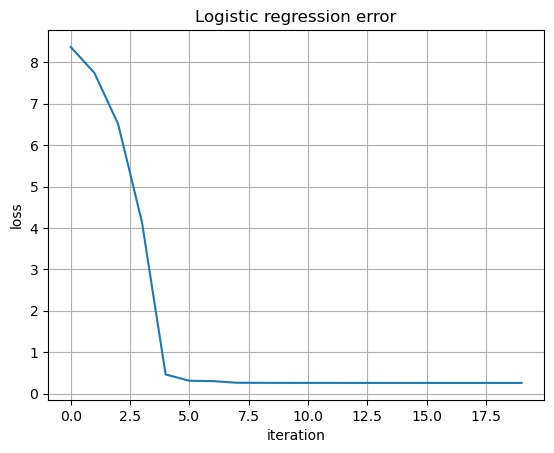

In [319]:
plt.figure()
plt.plot(Et)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Logistic regression error')
plt.grid('on')

plt.savefig('E_progress_AC.png')

Plot also the progress of the value of $w$ in 2D (slope + bias parts of $w$) during the optimisation. Save the figure as `w_progress_2d_AC.png`.

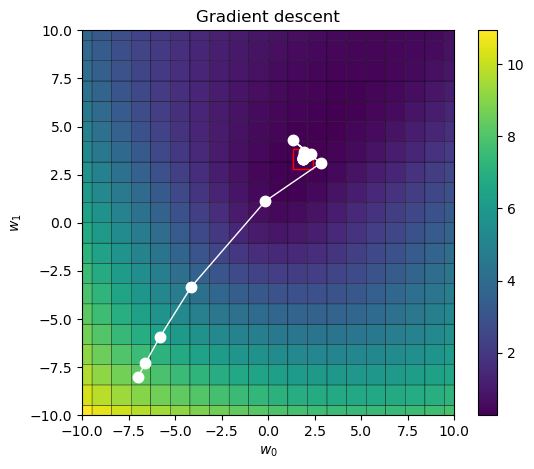

In [320]:
# feel free to modify this function for better visualization:
plot_gradient_descent(train_X, trn['labels'], logistic_loss, w, wt, Et)
plt.savefig('w_progress_2d_AC.png')

### Preparation for classification

Derive the analytical solution for the classification threshold on the (1D) data, i.e. find $x$ for which the aposteriori probabilities are both 0.5. Using the formula, complete the function `thr = get_threshold(w)`. This function is then used to plot the aposteriori probabilities.

In [321]:
# Unit Test:
thr = get_threshold(np.array([1.5, -0.7]))

np.testing.assert_almost_equal(thr, 2.142857142857143)

Verify the result once more by displaying it together with the a posteriori probabilities. Save the plot as ``aposteriori.png``.

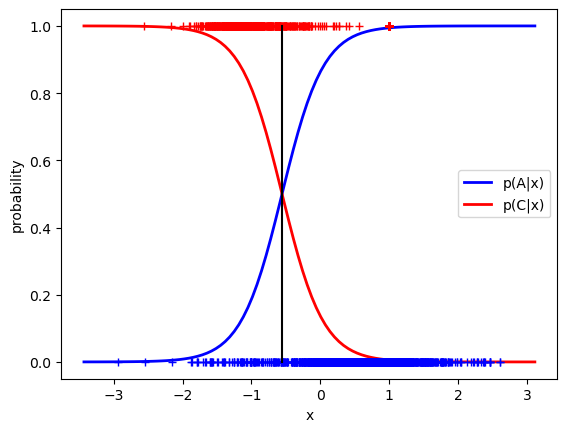

In [322]:
# show the aposteriori probabilities and the decision threshold
plot_aposteriori(train_X, trn['labels'], w)
plt.savefig('aposteriori.png')

### Image classification

As we have the logistic regression training implemented, we may start using it.

Complete the function `y = classify_images(X, w)` which uses the learned $w$ to classify the data in $X$.

In [323]:
# Unit Test:
y = classify_images(np.array([[1, 1, 1, 1, 1, 1, 1],[0.5, 1, 1.5, 2, 2.5, 3, 3.5]]), np.array([1.5, -0.5]))

np.testing.assert_array_equal(y, [1, 1, 1, 1, 1, -1, -1])

Use the function `classify_images` to classify the letters in the `tst` set and compute the classification error.

Make sure that you use the data normalisation computed on the _training_ data!

In [324]:
# Load test letter data
testX = compute_measurements(tst['images'], params)[0]
ones = np.ones(testX.shape[0])
testX = np.vstack((ones, testX))

# Classify letter test data and calculate classification error
classifiedLabels = classify_images(testX, w)
errors = np.where(classifiedLabels != tst['labels'], 1, 0)
testError = np.sum(errors, dtype=np.float64) / errors.size
print('Letter classification error: {:.2f}%'.format(testError * 100))

Letter classification error: 7.00%


### Visualize classification results

Finally, we visualize the classification and save the figure as ``classif_AC.png``.

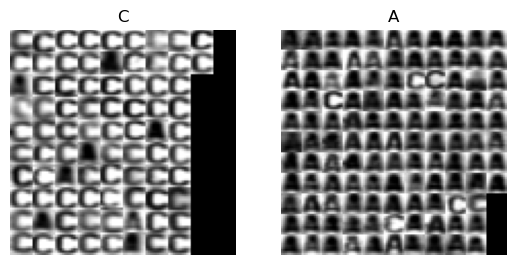

In [325]:
show_classification(tst['images'], classifiedLabels, 'CA')
plt.savefig('classif_AC.png')

## Part 2: MNIST digit classification
Next we apply the method to a similar task of digit classification. However, instead of using a one-dimensional measurement we will work directly in the 784-dimensional space (28 $\times$ 28, the size of the images) using the pixel values as individual dimensions.


### Load the data

Load the data from `mnist_trn.npz`. Beware that the structure of the data is slightly different from the previous task.

In [326]:
# Load training data
data = np.load("mnist_trn.npz", allow_pickle=True)
X, y, imsize = data["X"], data["y"], data["imsize"]

Repeat the steps from the Part 1 and produce similar outputs.

### Prepare the data

In [327]:
# Add x0 = 1 (for the bias term)
ones = np.ones(X.shape[1])
X = np.vstack((ones, X))

# Training - gradient descent of the logistic loss function
np.random.seed(1) # to get the same example outputs
w_init = np.random.rand(X.shape[0])
epsilon = 1e-2

### Train the classifier

In [328]:
w, _, Et = logistic_loss_gradient_descent(X, y, w_init, epsilon)

### Plot the training progress

Display the training progress and save the figure as ``E_progress_MNIST.png``.

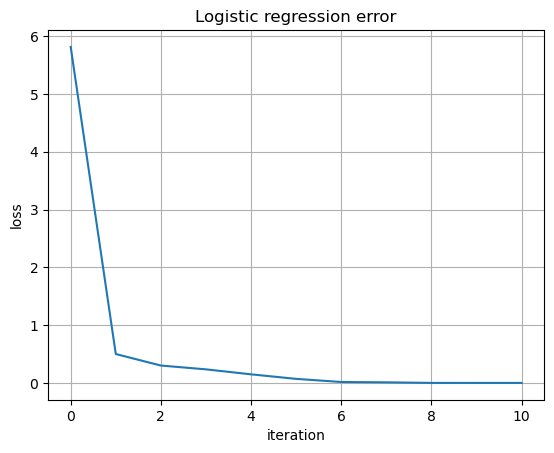

In [329]:
# Plot the progress of the gradient descent
plt.figure()
plt.plot(Et)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Logistic regression error')
plt.grid('on')

plt.savefig('E_progress_MNIST.png')

### Classify the test data and calculate the classification error

In [330]:
# Load test data
data = np.load("mnist_tst.npz", allow_pickle=True)
X, y, imsize = data["X"], data["y"], data["imsize"]

ones = np.ones(X.shape[1])
X = np.vstack((ones, X))

In [331]:
# Classify MNIST test data and calculate classification error
classifiedLabels = classify_images(X, w)
errors = np.where(classifiedLabels != data['y'], 1, 0)

testError = np.sum(errors, dtype=np.float64) / errors.size
print('MNIST digit classification error: {:.2f}%'.format(testError * 100))

MNIST digit classification error: 0.10%


### Visualize the MNIST classification

Show the classification results. Save the figure as ``classif_MNIST.png``.

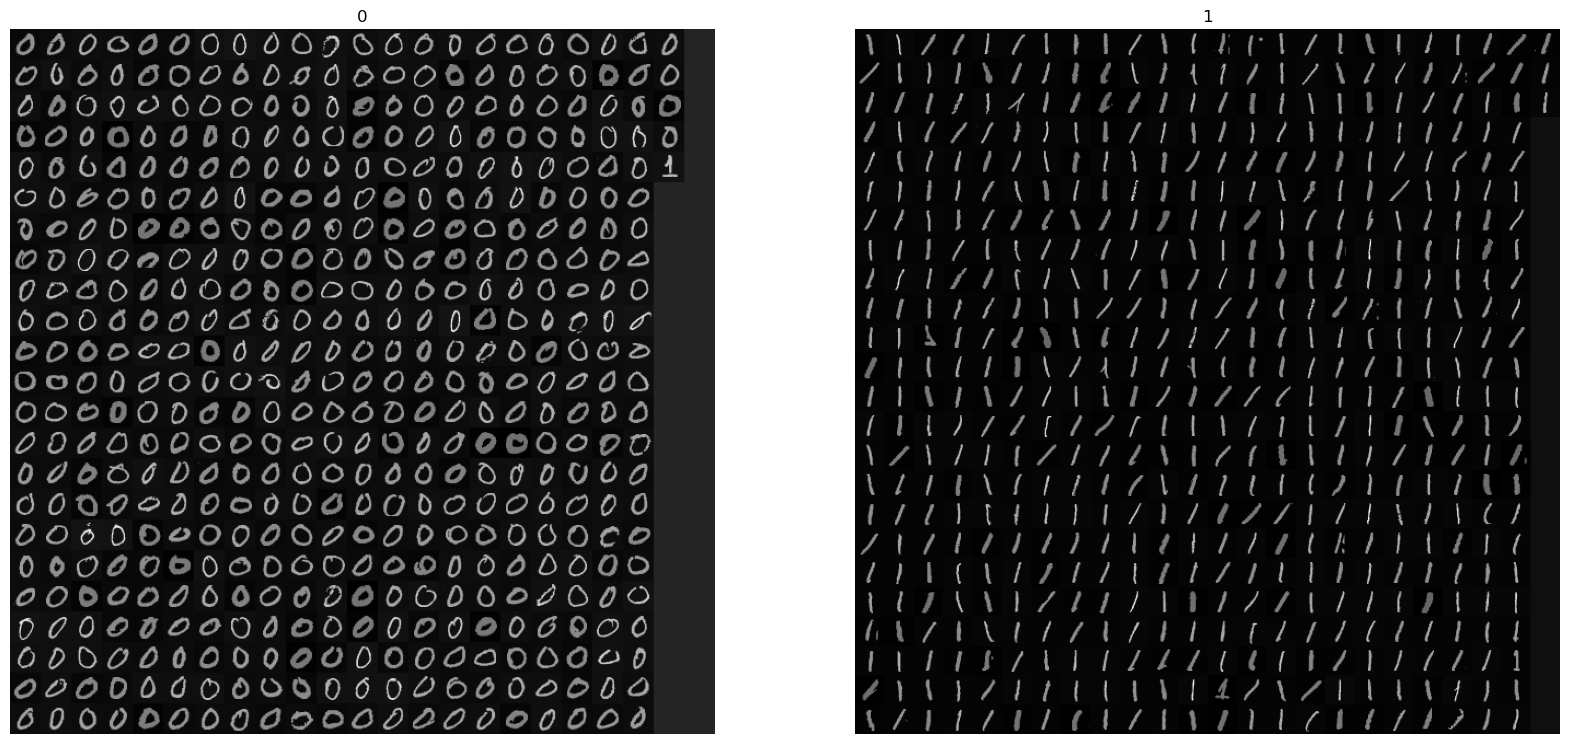

In [332]:
# Visualize classification results
show_mnist_classification(X[1:, :], classifiedLabels, imsize)
plt.savefig('classif_MNIST.png')

### Examining the feature weights

Because of our choice of image features, we now have a weight for each pixel (+ a bias term), which allows the following visualization. We can to some extend see which pixels play the most important role in the decision.

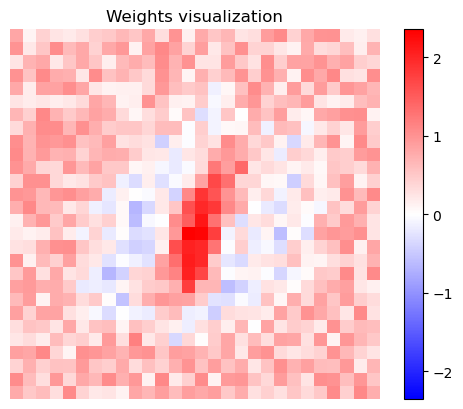

In [333]:
w_img = w[1:].reshape(imsize)
vmax = np.max(np.abs(w_img))
# https://matplotlib.org/stable/users/explain/colors/colormaps.html#diverging
sm = plt.imshow(w_img, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar(sm)
plt.axis('off')
plt.title('Weights visualization')
plt.savefig('weight_image.png')

## Submission to the BRUTE Upload System

To fulfill this assignment, you need to submit these files (all packed in one ''.zip'' file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:
  - `logreg.ipynb` - a script for data initialization, calling of the implemented functions and plotting of their results (for your convenience, will not be checked)
  - `logreg.py` - containing the following implemented methods:
    - `logistic_loss` - a function which computes the logistic loss
    - `logistic_loss_gradient` - a function for computing the logistic loss gradient
    - `logistic_loss_gradient_descent` - gradient descent on logistic loss
    - `get_threshold` - analytical decision boundary solution for the 1D case
    - `classify_images` - given the log. reg. parameters, classifies the input data into {-1, +1}.
  - `E_progress_AC.png`, `w_progress_2d_AC.png`, `aposteriori.png`, `classif_AC.png`, `E_progress_MNIST.png`, `classif_MNIST.png` - images specified in the tasks

When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.

## Bonus task

Implement the logistic regression with dimensionality lifting as shown in the following figure from [1]. The figure assumes $w$ being the class label and $\phi$ the sought vector. Generate similar outputs to verify a successful implementation.

<img src="assets/prince_nonlin_logreg.png" width="700">


## References 

[1] Simon J. D. Prince, __[Computer Vision: Models, Learning and Inference](http://www.computervisionmodels.com/)__, 2012